<a href="https://colab.research.google.com/github/ossamum/google-meridian/blob/main/Google_Meridian_Simulated_Data_National.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## What This Model Enables

With this fitted marketing mix model, we can now generate **actionable insights** and **data-driven recommendations** for budget allocation and performance optimization.

### 1. Channel ROI & Efficiency
- Quantifies **Return on Investment** for each media channel.
- Identifies **high-performing channels** that deliver the most conversions per dollar.
- Highlights **low-efficiency channels** where spend could be reduced without hurting KPI performance.

### 2. Media Contribution Analysis
- Decomposes total conversions into **baseline demand** (non-media factors) and **media-driven demand**.
- Measures each channel’s **incremental contribution** to the KPI.
- Detects overlaps or synergies between channels for smarter cross-channel planning.

### 3. Budget Optimization
- Uses the **optimization output** to simulate alternative spend scenarios.
- Reallocates budgets across channels to **maximize total conversions** within a fixed spend.
- Projects the **incremental lift** achievable under the optimized plan.

### 4. Scenario & Sensitivity Testing
- Run *what-if* analyses to forecast the impact of:
  - Increasing or decreasing spend in a channel.
  - Introducing new budget constraints.
  - Changes in market demand or competitive pressure.
- Understand how sensitive the KPI is to each channel’s spend level.

### 5. Strategic Planning
- Support **quarterly and annual media planning** with evidence-based channel mix recommendations.
- Provide a defensible, quantitative basis for budget negotiations with stakeholders.
- Align marketing investments with **measurable business outcomes**.

---

**In summary:**  
This model transforms raw spend and performance data into a **decision-support tool** that not only explains past performance but also **optimizes future spend** to maximize ROI and conversions.


# Importings

In [1]:
# Install meridian: from PyPI @ latest release
!pip install --upgrade -q google-meridian[colab,and-cuda]

# Install meridian: from PyPI @ specific version
# !pip install google-meridian[colab,and-cuda]==1.1.1

# Install meridian: from GitHub @HEAD
# !pip install --upgrade "google-meridian[colab,and-cuda] @ git+https://github.com/google/meridian.git@main"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.5/615.5 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 82.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 234.6/234.6 kB 22.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 888.0/888.0 kB 61.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 120.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 

In [18]:
import arviz as az
import IPython
from meridian import constants
from meridian.analysis import analyzer
from meridian.analysis import formatter
from meridian.analysis import optimizer
from meridian.analysis import summarizer
from meridian.analysis import visualizer
from meridian.data import data_frame_input_data_builder
from meridian.data import test_utils

from meridian.model import model
from meridian.model import prior_distribution
from meridian.model import spec
import numpy as np
import pandas as pd
# check if GPU is available
from psutil import virtual_memory
import tensorflow as tf
import tensorflow_probability as tfp

from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
import matplotlib.pyplot as plt

ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))
print(
    'Num GPUs Available: ',
    len(tf.config.experimental.list_physical_devices('GPU')),
)
print(
    'Num CPUs Available: ',
    len(tf.config.experimental.list_physical_devices('CPU')),
)

Your runtime has 13.6 gigabytes of available RAM

Num GPUs Available:  1
Num CPUs Available:  1


In [ ]:
pd.options.display.max_columns = None

# Data loading and processing

## Dataset Description: `Simulated_Data_National.csv`

This dataset contains simulated, time-series marketing performance data across multiple channels, combined with economic and competitive indicators.  
Each row represents aggregated weekly data.

### Columns Overview

- **time**  
  Weekly timestamp (YYYY-MM-DD) indicating the start date of the reporting week.

- **ChannelX_impression** *(X = 0 to 5)*  
  The total number of ad impressions served on a given marketing channel during the week.

- **ChannelX_spend** *(X = 0 to 5)*  
  Total advertising spend (in USD) for the corresponding channel in that week.

- **GQV** *(Gross Query Volume)*  
  Represents an index of consumer search demand or query volume relative to a baseline.

- **Geo_GDP**  
  Weekly percentage change in the GDP for the target geography, serving as a macroeconomic signal.

- **Competitor_Discount**  
  Indicator of competitive pressure, measured as the relative discounting or promotional intensity from competitors (positive = aggressive discounting, negative = reduced activity).

- **conversions**  
  Total number of conversions (e.g., purchases, sign-ups) generated across all channels during the week.

- **revenue_per_conversion**  
  Average revenue generated per conversion (USD).

- **Channel4_reach / Channel5_reach**  
  The estimated number of unique users reached by channels 4 and 5, respectively.

- **Channel4_frequency / Channel5_frequency**  
  Average number of times a reached user was exposed to ads in channels 4 and 5.

In [5]:
df = (
    pd.read_csv('Simulated_Data_National.csv')
    .drop(columns=['Unnamed: 0'])
    .assign(time = lambda x: pd.to_datetime(x['time']))
)
df.shape

(156, 22)

In [ ]:
df.head(3)

,time,Channel0_impression,Channel1_impression,Channel2_impression,Channel3_impression,Channel4_impression,Channel5_impression,Channel0_spend,Channel1_spend,Channel2_spend,Channel3_spend,Channel4_spend,Channel5_spend,GQV,Geo_GDP,Competitor_Discount,conversions,revenue_per_conversion,Channel4_reach,Channel5_reach,Channel4_frequency,Channel5_frequency
0,2021-01-25,22196304.0,5712889.0,13918631.0,17072912.0,17343480.0,2767630.0,190494.19,56647.516,121492.20,132557.12,141236.69,21693.094,-0.529628,-24.884350,-2.655724,342742370.0,0.020010,8099505.0,1464881.0,2.141301,1.889321
1,2021-02-01,27658918.0,9929533.0,10223184.0,27668936.0,12784942.0,10120146.0,237375.72,98458.660,89235.58,214826.55,104114.22,79323.200,13.778649,-18.486712,-17.554234,363192200.0,0.019985,6920225.0,5017149.0,1.847475,2.017111
2,2021-02-08,45034828.0,13968472.0,29166668.0,44537184.0,30223412.0,11200601.0,386500.10,138507.720,254588.45,345794.66,246124.44,87791.970,30.576717,-38.086990,38.771027,415416400.0,0.020015,12528367.0,6002935.0,2.412398,1.865854


In [ ]:
df['time'].min(), df['time'].max()

('2021-01-25', '2024-01-15')

In [6]:
# check if gaps in time
assert len(pd.date_range(df['time'].min(), df['time'].max(), freq='7D')) == df.shape[0]

In [7]:
# check if any null values
assert df.isna().sum().any() == False

# Exploratory Data Analysis (EDA)

In [31]:
decomposition = seasonal_decompose(df.set_index('time')['conversions'], model='additive', period=52)

## Interpretation of Conversions Seasonal Decomposition

The seasonal decomposition of the `conversions` time series reveals three main components:

### 1. Trend
- The **trend** line shows the underlying long-term movement in conversions, independent of short-term fluctuations.
- In this dataset, conversions show a moderate upward movement during early 2022, peaking around mid–2022, followed by a gradual decline through early 2023.
- This may indicate shifts in overall marketing effectiveness, budget allocation, or external market conditions.

### 2. Seasonality
- The **seasonal** component captures repeating patterns occurring at a regular frequency (weekly pattern with yearly periodicity here).
- The decomposition suggests noticeable short-term periodic variations in conversions, potentially linked to campaign cycles, promotions, or seasonal consumer behavior.
- Peaks and troughs appear consistently spaced, indicating recurring demand surges and drops.

### 3. Residuals
- The **residual** (or remainder) represents random fluctuations not explained by trend or seasonality.
- The residuals appear relatively small compared to the trend, but with occasional large deviations, possibly caused by exceptional events (e.g., major promotions, disruptions, or market shocks).

### Overall Insights
- The time series is **not purely random** — there is a clear structural component with both a trend and seasonal patterns.
- These insights suggest that predictive models should incorporate **trend and seasonal adjustments** to improve accuracy.
- Further statistical checks (e.g., autocorrelation plots, seasonal strength metrics) could quantify the seasonality and help validate its stability over time.


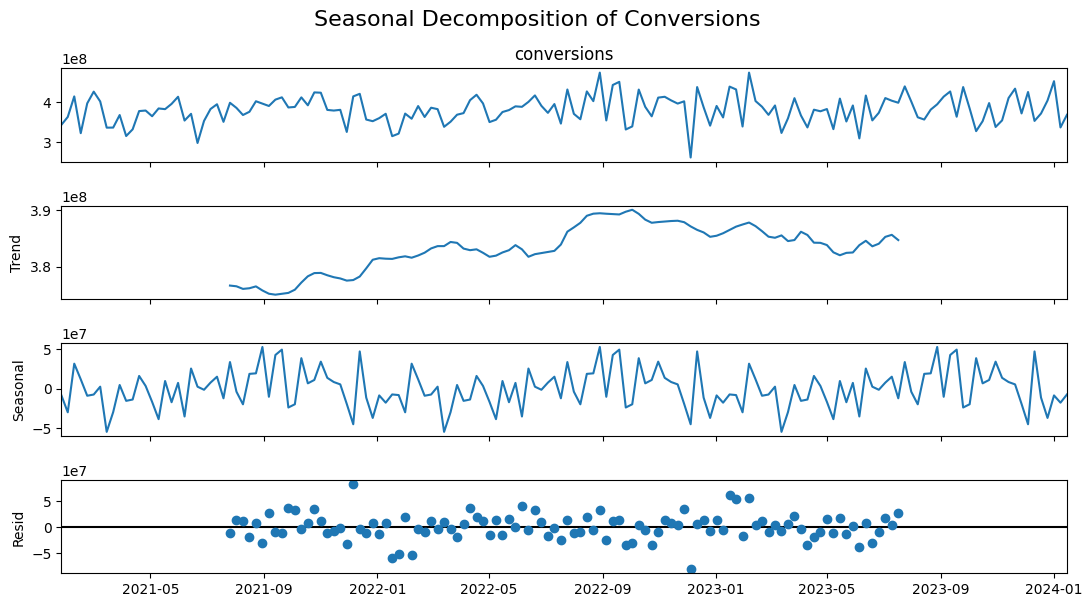

In [32]:
# Plot decomposition
fig = decomposition.plot()
fig.set_size_inches(12, 6)
plt.suptitle('Seasonal Decomposition of Conversions', fontsize=16, y=1.02)
plt.show()

In [12]:
all_channels = [f'Channel{c}' for c in range(6)]
all_channels_spend = [f'{c}_spend' for c in all_channels]
all_channels_impression = [f'{c}_impression' for c in all_channels]

The clustermap shows correlations between **spend** and **impressions** for each marketing channel, with hierarchical clustering to group similar patterns.

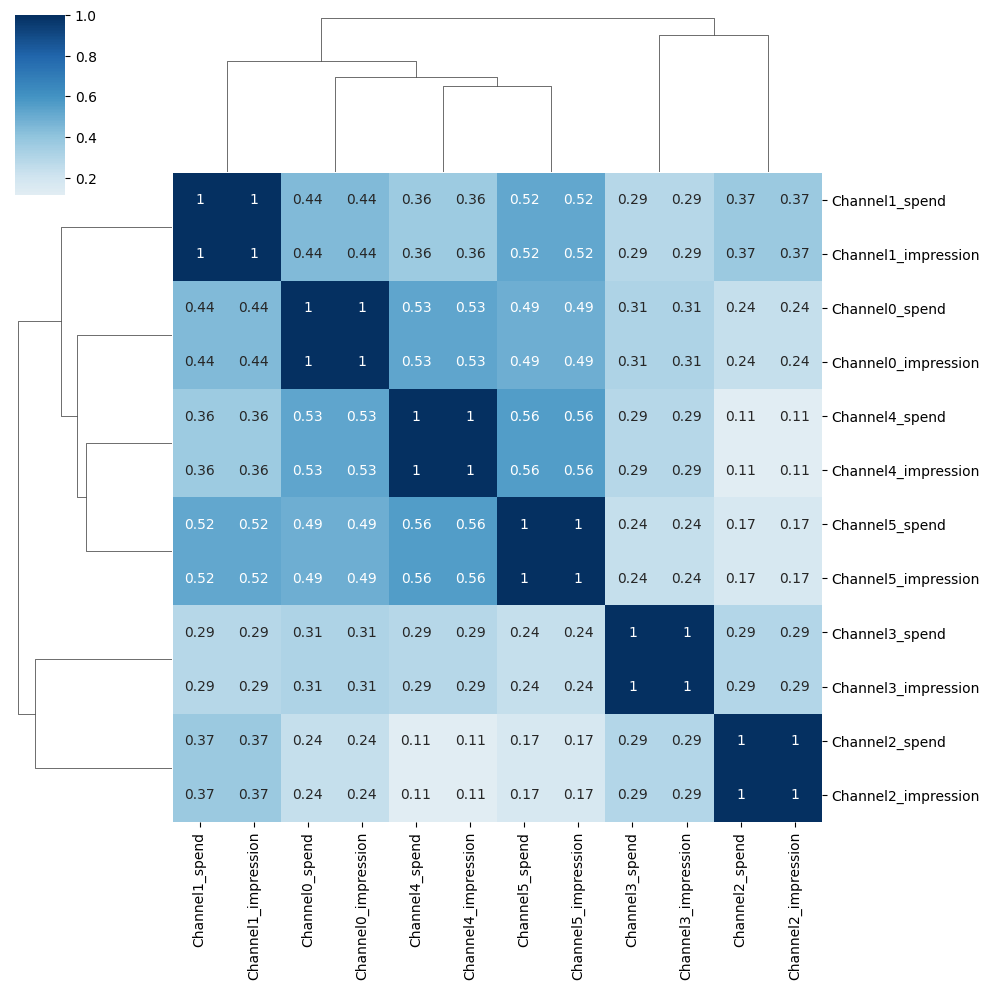

In [14]:
sns.clustermap(df[all_channels_spend + all_channels_impression].corr(), annot=True, cmap='RdBu', center=0);

## Channel Impressions Over Time

The plots show weekly ad impressions for each channel from 2021 to early 2024.

### Observations
- **General stability:** Most channels maintain relatively consistent impression levels, with occasional peaks and drops.
- **Channel0 & Channel3:** Higher average impressions compared to others, suggesting heavier investment or higher audience capacity.
- **Channel1 & Channel2:** Moderate volumes with noticeable spikes, possibly linked to short-term campaigns.
- **Channel4 & Channel5:** Lower but more variable impressions, indicating selective or burst-style campaigns.
- **Seasonal-like fluctuations:** Some channels exhibit recurring peaks, hinting at possible seasonal marketing pushes.

**Implication:** Impression trends differ by channel, likely reflecting varied budget allocation strategies and campaign timing.


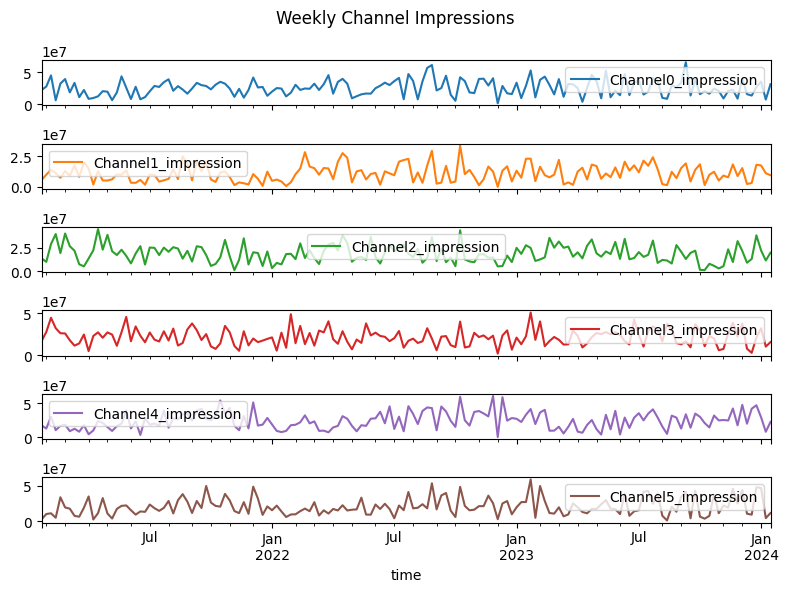

In [34]:
df.set_index('time')[all_channels_impression].plot(title='Weekly Channel Impressions', subplots=True, figsize=(8, 6))
plt.tight_layout()
plt.show()

## Correlation Clustermap – Impressions, External Factors & Outcomes

This clustermap shows correlations between channel impressions, external factors, and performance metrics, with hierarchical clustering revealing related variables.

### Key Insights
- **Channel Impression Clusters**  
  - Channels 0, 1, 4, and 5 impressions form a group with moderate correlations, suggesting some synchronized campaign timing or shared drivers.
  - Channel 2 and Channel 3 impressions are closely linked but form a separate cluster, indicating distinct activity patterns.
  
- **External Factors**  
  - `GQV` (Gross Query Volume) is positively correlated with Channel2 impressions and moderately with Channel0/Channel1, indicating demand signals may drive certain channels more.
  - `Geo_GDP` shows a moderate positive link with Channel3 impressions but a negative correlation with `GQV` (-0.57), suggesting GDP and search demand move in opposite directions in this dataset.
  - `Competitor_Discount` has the strongest positive link to Channel4 and Channel5 impressions, possibly reflecting competitive responses in those channels.

- **Business Outcomes**  
  - `Conversions` are moderately correlated with Channel4 and Channel5 impressions, indicating these channels may contribute to volume.
  - `Revenue_per_conversion` is largely uncorrelated with impressions, suggesting that higher exposure does not necessarily increase average order value.

**Implication:**  
The clustering reveals two main impression groups, distinct external drivers for different channels, and that volume (conversions) is not directly tied to value per conversion. This can guide both **media mix modeling** and **channel-specific strategy**.


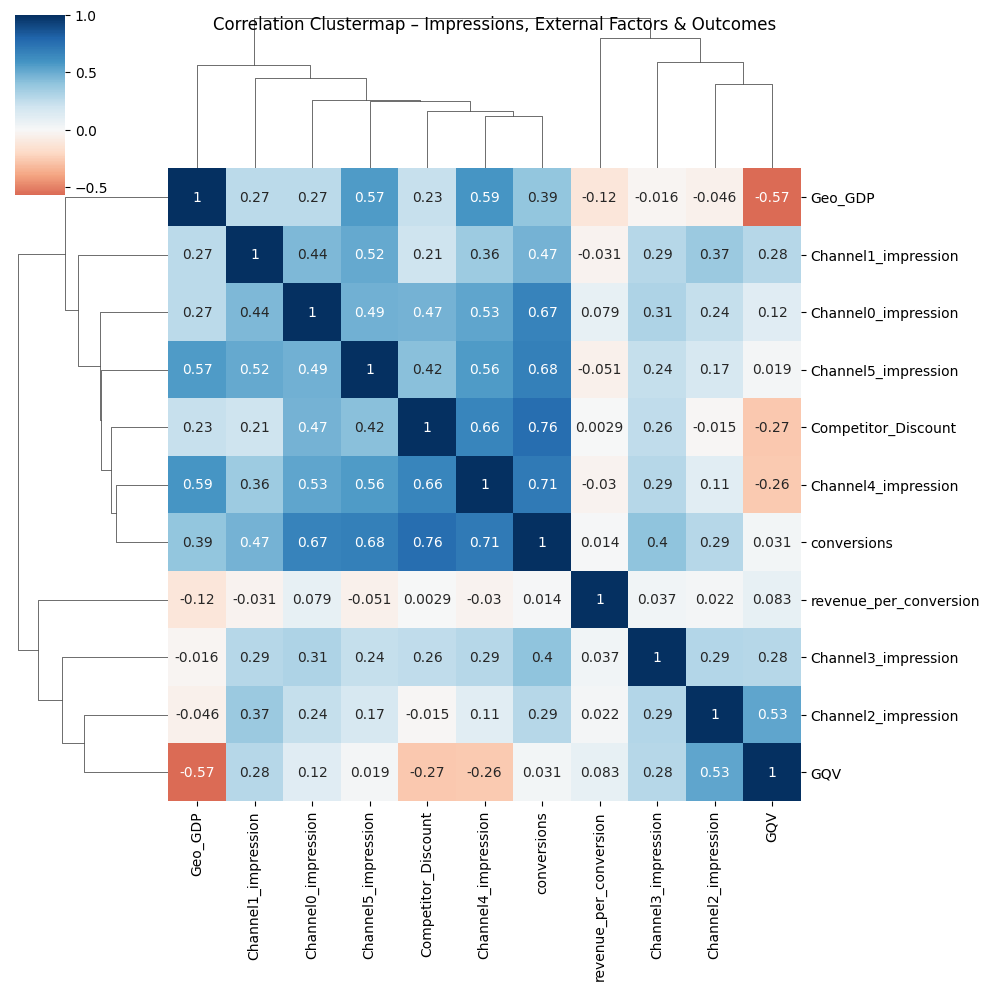

In [41]:
sns.clustermap(df[
    all_channels_impression +
     [
      'GQV',
      'Geo_GDP',
      'Competitor_Discount',
      'conversions',
      'revenue_per_conversion']
  ].corr(), annot=True, cmap='RdBu', center=0)
plt.suptitle('Correlation Clustermap – Impressions, External Factors & Outcomes')
plt.show()

## Lagged Correlation Between Impressions and Conversions

This plot shows the Pearson correlation between each channel’s impressions and conversions across lags from 0 to 14 days.

### Key Observations
- **Strong immediate effect (Lag 0):**  
  - All channels have their highest correlation with conversions at lag 0, especially Channel5, Channel4 and Channel0 (≈0.67–0.70).  
  - Suggests conversions tend to occur on the same day/week as impressions.

- **Sharp drop after Lag 0:**  
  - Correlations decline rapidly and sometimes become slightly negative for lags 1–2, indicating limited delayed impact for most channels.

- **Small secondary peaks:**  
  - Some channels show mild positive bumps at lags ~3, 7, and 10 days, possibly reflecting delayed conversion behavior from certain audiences or multi-touch journeys.
  - Channel0 and Channel5 have small rises around lag 10.

**Implication:**  
Most conversion responses are immediate, with limited but notable delayed effects in certain channels. This insight can inform attribution models by emphasizing same-period conversions while accounting for short-term carryover effects.


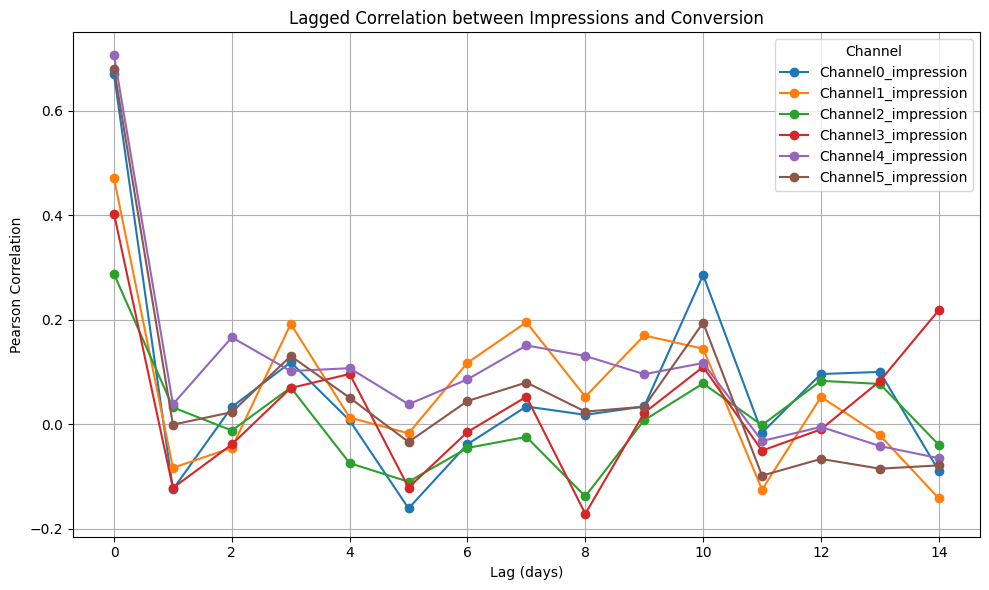

In [42]:
# Max lag to test
max_lag = 14

# Dictionary to store correlations
correlation_results = {col: [] for col in all_channels_impression}

# Compute correlations for each lag
for lag in range(0, max_lag + 1):
    for col in all_channels_impression:
        # Shift the impression data forward by lag days
        shifted = df[col].shift(lag)
        corr = df['conversions'].corr(shifted)
        correlation_results[col].append(corr)

# Convert results to a DataFrame
corr_df = pd.DataFrame(correlation_results, index=range(0, max_lag + 1))
corr_df.index.name = 'Lag'

# Plot the lagged correlations
corr_df.plot(figsize=(10, 6), marker='o')
plt.title('Lagged Correlation between Impressions and Conversion')
plt.xlabel('Lag (days)')
plt.ylabel('Pearson Correlation')
plt.grid(True)
plt.legend(title='Channel')
plt.tight_layout()
plt.show()


## Spend vs. Impression Variance by Channel

This scatter plot compares **total spend** (x-axis) and **variance in impressions** (y-axis) for each channel.

### Key Observations
- **Channel4**: High spend and the highest impression variance, suggesting aggressive but inconsistent delivery — possibly campaign bursts or varying budgets.
- **Channel0**: Similar high spend but slightly lower variance than Channel4, indicating more stable impression delivery.
- **Channel5**: Moderate spend with high variance, implying targeted but fluctuating campaigns.
- **Channels2 & 3**: Mid-level spend with moderate variance, suggesting balanced and steady activity.
- **Channel1**: Lowest spend and lowest variance, representing consistent low-level investment.

**Implication:**  
High variance channels (4, 0, 5) may be more influenced by campaign timing and budget swings, while low variance channels (1, 2, 3) show steadier exposure patterns. This can guide decisions on whether to smooth delivery or maintain burst strategies depending on campaign goals.


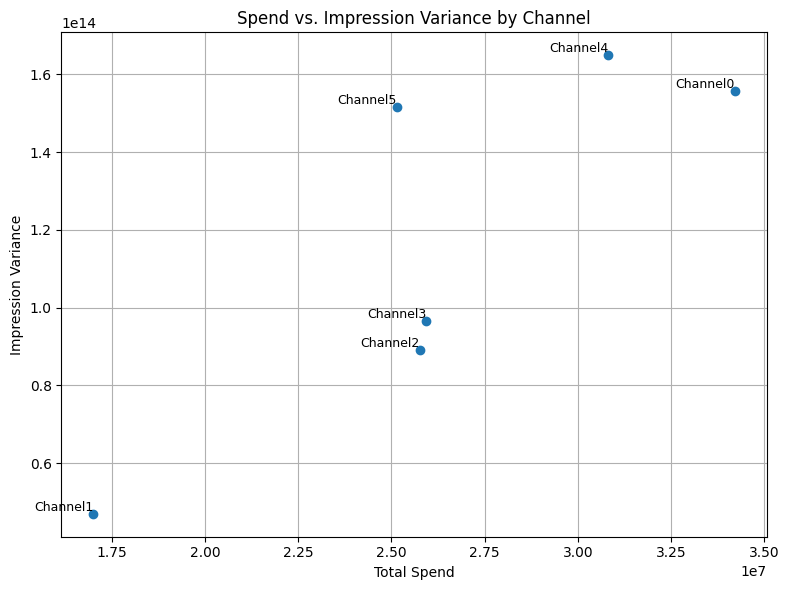

In [ ]:
# Calculate x and y values
x_values = df.iloc[:, df.columns.str.contains('spend')].sum().tolist()
y_values = df.iloc[:, df.columns.str.contains('impression')].var().tolist()

# Generate labels
labels = [f'Channel{i}' for i in range(len(x_values))]

# Plot the scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(x_values, y_values)

# Add text labels near each point
for i, label in enumerate(labels):
    plt.text(x_values[i], y_values[i], label, fontsize=9, ha='right', va='bottom')

plt.xlabel("Total Spend")
plt.ylabel("Impression Variance")
plt.title("Spend vs. Impression Variance by Channel")
plt.grid(True)
plt.tight_layout()
plt.show()

# Model Specification

## Modeling Rationale & Schema Choices

### Why two channel sets?
- **Impressions-based media (`Channel0–Channel3`)**  
  These channels report *impressions* directly. In MMM terms, they’re classic “GRP/impressions” inputs where we’ll model **carryover/adstock** and **diminishing returns** on the impressions signal.
- **Reach/Frequency-based media (`Channel4–Channel5`)**  
  These channels expose **reach** and **frequency** explicitly. Instead of treating them like pure impressions, we model their *effective impressions* (e.g., `reach × frequency`) or include reach & frequency separately to capture **nonlinear frequency effects** (wear-in/wear-out).  
  > Our earlier clustermaps showed Channels 4–5 behave differently and move together—justifying a distinct treatment.

### KPI choice
- `kpi_type='non_revenue'` → The optimization target is a **volume KPI** (e.g., `conversions`) rather than revenue.  
  - This matches our decomposition and lag analyses, where **conversions** respond most strongly and immediately to media.  
  - Revenue-per-conversion is more volatile and weakly tied to media, so we keep it out of the objective (it can still be a control if needed).

### Time & geo setup
- `default_time_column='time'` aligns with the weekly index we’ve been using for decomposition and trend analysis.  
- `default_geo_column` is commented out because this dataset is **national**; no geo split is needed. If we add regions later, we can enable it for hierarchical modeling.

### What the builder does
Using `DataFrameInputDataBuilder` standardizes the raw dataframe into Meridian’s schema:
- **Maps inputs**  
  - Impressions channels → exposure variables for adstock/saturation.  
  - Reach/Frequency channels → either combined effective impressions or separate `reach`, `frequency` features.
- **KPI binding**  
  - Sets the target series (non-revenue KPI: `conversions`) and aligns it with media exposures by time.
- **Controls & context (optional but recommended)**  
  - External drivers like **`GQV`**, **`Geo_GDP`**, **`Competitor_Discount`** can be added as controls to isolate media effects.
- **Data hygiene**  
  - Ensures sorting, type coercion, missing-value policy, and consistent weekly cadence before modeling.

### Assumptions carried from EDA
- **Short carryover**: Lagged correlations peak at **lag 0** with minor bumps at ~3–10 days → we’ll start with **short adstock** windows.  
- **Nonlinear response**: Diminishing returns expected, especially for Channels 0/4/5 with high volume/variance → we’ll include **saturation**.  
- **Distinct behavior for 4–5**: Clustered together and correlate with conversions; modeling them via reach/frequency should capture frequency-sensitive effects better than raw impressions.

### Outcome
`data = builder.build()` produces a clean, schema-compliant dataset ready for Meridian’s modeling pipeline—separating channel mechanics (impressions vs. reach/frequency), targeting **conversions** as the KPI, and paving the way for carryover + saturation estimation with appropriate controls.


In [43]:
# --- Channel sets from schema ---
media_channels = ["Channel0","Channel1","Channel2","Channel3"]     # impressions-based
rf_channels    = ["Channel4","Channel5"]                           # reach/frequency-based

In [44]:
# --- Builder ---
builder = data_frame_input_data_builder.DataFrameInputDataBuilder(
    kpi_type='non_revenue',
    default_time_column='time',
    default_media_time_column='time',
    default_kpi_column='conversions',
    default_revenue_per_kpi_column='revenue_per_conversion'
)

In [45]:
builder = (
    builder.with_kpi(df)
           .with_revenue_per_kpi(df)
           .with_controls(df, control_cols=["GQV", "Geo_GDP", "Competitor_Discount"])
)

In [46]:
# Impressions-based media: Channels 0–3
builder = builder.with_media(
    df,
    media_cols=[f"{c}_impression" for c in media_channels],
    media_spend_cols=[f"{c}_spend" for c in media_channels],
    media_channels=media_channels,
)

# Reach/Frequency media: Channels 4–5
builder = builder.with_reach(
    df,
    reach_cols=[f"{c}_reach" for c in rf_channels],
    frequency_cols=[f"{c}_frequency" for c in rf_channels],
    rf_channels=rf_channels,
    rf_spend_cols=[f"{c}_spend" for c in rf_channels],
)

In [47]:
data = builder.build()

## Priors Specification Rationale

### ROI Priors
We specify **log-normal priors** for the Return on Investment (ROI) of each media channel:

- **`roi_mu = 0.0`**  
  - This is the mean of the log-space distribution.  
  - In linear space, it implies a median ROI of **exp(0) = 1.0**, meaning the prior is centered on "break-even" performance (1 unit of KPI per unit of spend), without bias toward over- or under-performance.

- **`roi_sigma = 1.5`**  
  - Controls the spread of the log-normal distribution.  
  - A higher sigma allows for substantial variation between channels, accommodating both low-ROI and high-ROI possibilities while remaining weakly informative.

### Why Log-Normal?
- ROI is **strictly positive** — log-normal ensures the distribution never produces negative values.
- Skewed shape better reflects real-world ROI distributions, where most channels cluster around moderate performance but some can achieve very high ROI.

In [48]:
roi_mu = 0.0  # Mu for ROI prior for each media channel.
roi_sigma = 1.5  # Sigma for ROI prior for each media channel.
priors = prior_distribution.PriorDistribution(
    roi_m=tfp.distributions.LogNormal(roi_mu, roi_sigma, name=constants.ROI_M)
)
model_spec = spec.ModelSpec(prior=priors, knots=5)  # prior_type by defect is 'roi'

In [49]:
mmm = model.Meridian(input_data=data, model_spec=model_spec)

/usr/local/lib/python3.11/dist-packages/meridian/model/model.py:66: UserWarning: In a nationally aggregated model, the `media_effects_dist` will be reset to `normal`.
  warnings.warn(


In [50]:
%%time
mmm.sample_prior(500, seed=0)
mmm.sample_posterior(
    n_chains=10, n_adapt=2000, n_burnin=500, n_keep=1000, seed=0
)

/usr/local/lib/python3.11/dist-packages/meridian/model/prior_distribution.py:915: UserWarning: Hierarchical distribution parameters must be deterministically zero for national models. tau_g_excl_baseline has been automatically set to Deterministic(0).
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/meridian/model/prior_distribution.py:915: UserWarning: Hierarchical distribution parameters must be deterministically zero for national models. eta_m has been automatically set to Deterministic(0).
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/meridian/model/prior_distribution.py:915: UserWarning: Hierarchical distribution parameters must be deterministically zero for national models. eta_rf has been automatically set to Deterministic(0).
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/meridian/model/prior_distribution.py:915: UserWarning: Hierarchical distribution parameters must be deterministically zero for national models. eta_om has been automatically set to

CPU times: user 7min 46s, sys: 17.5 s, total: 8min 3s
Wall time: 8min 11s


# Model Diagnostics

The **R-hat convergence diagnostic** assesses whether the Markov Chain Monte Carlo (MCMC) sampling has converged for each parameter in the model.

### Interpretation of Plot
- **R-hat (̂R)** values close to **1.0** indicate good convergence — chains are mixing well, and parameter estimates are stable.
- The **red line at 1.0** serves as the ideal reference; values below **1.01** are generally considered acceptable.

### Observations
- **Most parameters** (e.g., `alpha_m`, `beta_m`, `cc_m`, `gamma_c`) have R-hat values near 1.000–1.002, showing excellent convergence.
- **Slightly higher R-hat values** (~1.008–1.012) appear for `mu` and `knot_values`, but still within acceptable bounds.
- No parameters exceed the critical threshold (>1.05), so there is no evidence of poor mixing or non-convergence.

### Implications
- The sampling process is stable, and posterior estimates are reliable.
- Minor deviations in `mu` and `knot_values` suggest these parameters may benefit from:
  - Increasing the number of iterations.
  - Slightly adjusting priors to improve identifiability.
  - Checking for strong correlations with other parameters.

### Conclusion
The model shows **strong overall convergence**, with only minor room for improvement in a few spline-related parameters. Current diagnostics indicate that the posterior inferences are trustworthy for decision-making.


In [51]:
model_diagnostics = visualizer.ModelDiagnostics(mmm)
model_diagnostics.plot_rhat_boxplot()

alt.LayerChart(...)

### Expected vs. Actual Revenue

This plot compares **actual revenue** with the model’s **expected revenue** predictions and the **baseline revenue** (revenue without media influence).

### Interpretation of Lines
- **Actual (green)** – Observed revenue from the dataset.
- **Expected (blue)** – Model’s predicted revenue given historical media spend and other drivers.
- **Baseline (orange)** – Estimated revenue if all media channels were turned off, capturing only base demand from non-media factors.

### Observations
- **Close tracking** between expected (blue) and actual (green) lines indicates the model captures real-world revenue dynamics well.
- **Baseline revenue** is consistently lower than actual revenue, showing a substantial positive lift from media activity.
- The gap between **expected** and **baseline** varies over time, reflecting periods of higher or lower media-driven impact.

### Implications
- The model successfully explains most fluctuations in revenue, aligning closely with actual outcomes.
- Periods where **expected ≠ actual** may highlight:
  - Unmodeled events (e.g., promotions, market shocks).
  - Data noise or reporting inconsistencies.
  - Changes in market response not captured by the model’s priors.

### Conclusion
The alignment between expected and actual revenue suggests **good in-sample fit**.  
The difference from the baseline confirms that **media spend is a major revenue driver** in the modeled period.


In [53]:
model_fit = visualizer.ModelFit(mmm)
model_fit.plot_model_fit()

/usr/local/lib/python3.11/dist-packages/meridian/analysis/analyzer.py:590: UserWarning: The `aggregate_geos` argument is ignored in the national model. It will be reset to `True`.
  warnings.warn(


alt.LayerChart(...)

# Model Output

In [54]:
mmm_summarizer = summarizer.Summarizer(mmm)

In [55]:
filepath = '/content/'
mmm_summarizer.output_model_results_summary(
    'summary_output.html', filepath, df['time'].min(), df['time'].max()
)

/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:4779: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:4779: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/usr/local/lib/python3.11/dist-packages/meridian/analysis/analyzer.py:590: UserWarning: The `aggregate_geos` argument is ignored in the national model. It will be reset to `True`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/meridian/analysis/analyzer.py:590: UserWarning: The `aggregate_geos` argument is ignored in the national model. It will be reset to `True`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/meridian/analysis/analyzer.py:3103: UserWarning: Effectiveness is not reported because it does not have a clear interpretation by time period.
  warnings.warn(


In [56]:
IPython.display.HTML(filename=f'{filepath}/summary_output.html')

Dataset,R-squared,MAPE,wMAPE
All Data,0.85,3%,3%


# Optimization

In [57]:
%%time
budget_optimizer = optimizer.BudgetOptimizer(mmm)
optimization_results = budget_optimizer.optimize()

/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:4779: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:4779: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


CPU times: user 28.8 s, sys: 1.53 s, total: 30.4 s
Wall time: 30.7 s


In [58]:
optimization_results.output_optimization_summary(
    'optimization_output.html', filepath
)

/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:4779: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:4779: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


In [59]:
IPython.display.HTML(filename=f'{filepath}/optimization_output.html')

Channel,Non-optimized spend,Optimized spend
Channel0,22%,24%
Channel4,19%,21%
Channel5,16%,21%
Channel2,16%,14%
Channel3,16%,13%
Channel1,11%,7%
